In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Time-series Forecasting
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:

# Use raw string (r'...') or replace backslashes with forward slashes for the file path
df = pd.read_csv(r'C:\Users\lenovo1\Desktop\Time Series Forecasting\data_original.csv', 
                 index_col=0, parse_dates=['Date'])

# Resetting the index if needed
df = df.reset_index(drop=True)
df

Date Device Category  Sessions
0    2014-01-01         desktop   1032805
1    2014-01-02         desktop   2359710
2    2014-01-03         desktop   2033439
3    2014-01-04         desktop    975623
4    2014-01-05         desktop   1237064
...         ...             ...       ...
6190 2019-08-23          tablet       797
6191 2019-08-24          tablet       717
6192 2019-08-25          tablet       398
6193 2019-08-26          tablet       199
6194 2019-08-27          tablet        80

[6195 rows x 3 columns]

In [3]:
# Grouping by date and summing the sessions across devices
df1 = df.groupby('Date').sum(numeric_only=True)
df1

Sessions
Date                
2014-01-01   1662852
2014-01-02   3192293
2014-01-03   2855860
2014-01-04   1806651
2014-01-05   1945606
...              ...
2019-08-23     33576
2019-08-24     12915
2019-08-25      9664
2019-08-26     11532
2019-08-27      1075

[2065 rows x 1 columns]

# Exploratory Data Analysis


In [4]:
display(df1.describe())


Sessions
count  2.065000e+03
mean   2.789659e+06
std    1.513218e+06
min    1.075000e+03
25%    1.844087e+06
50%    2.850289e+06
75%    3.634547e+06
max    3.921783e+07

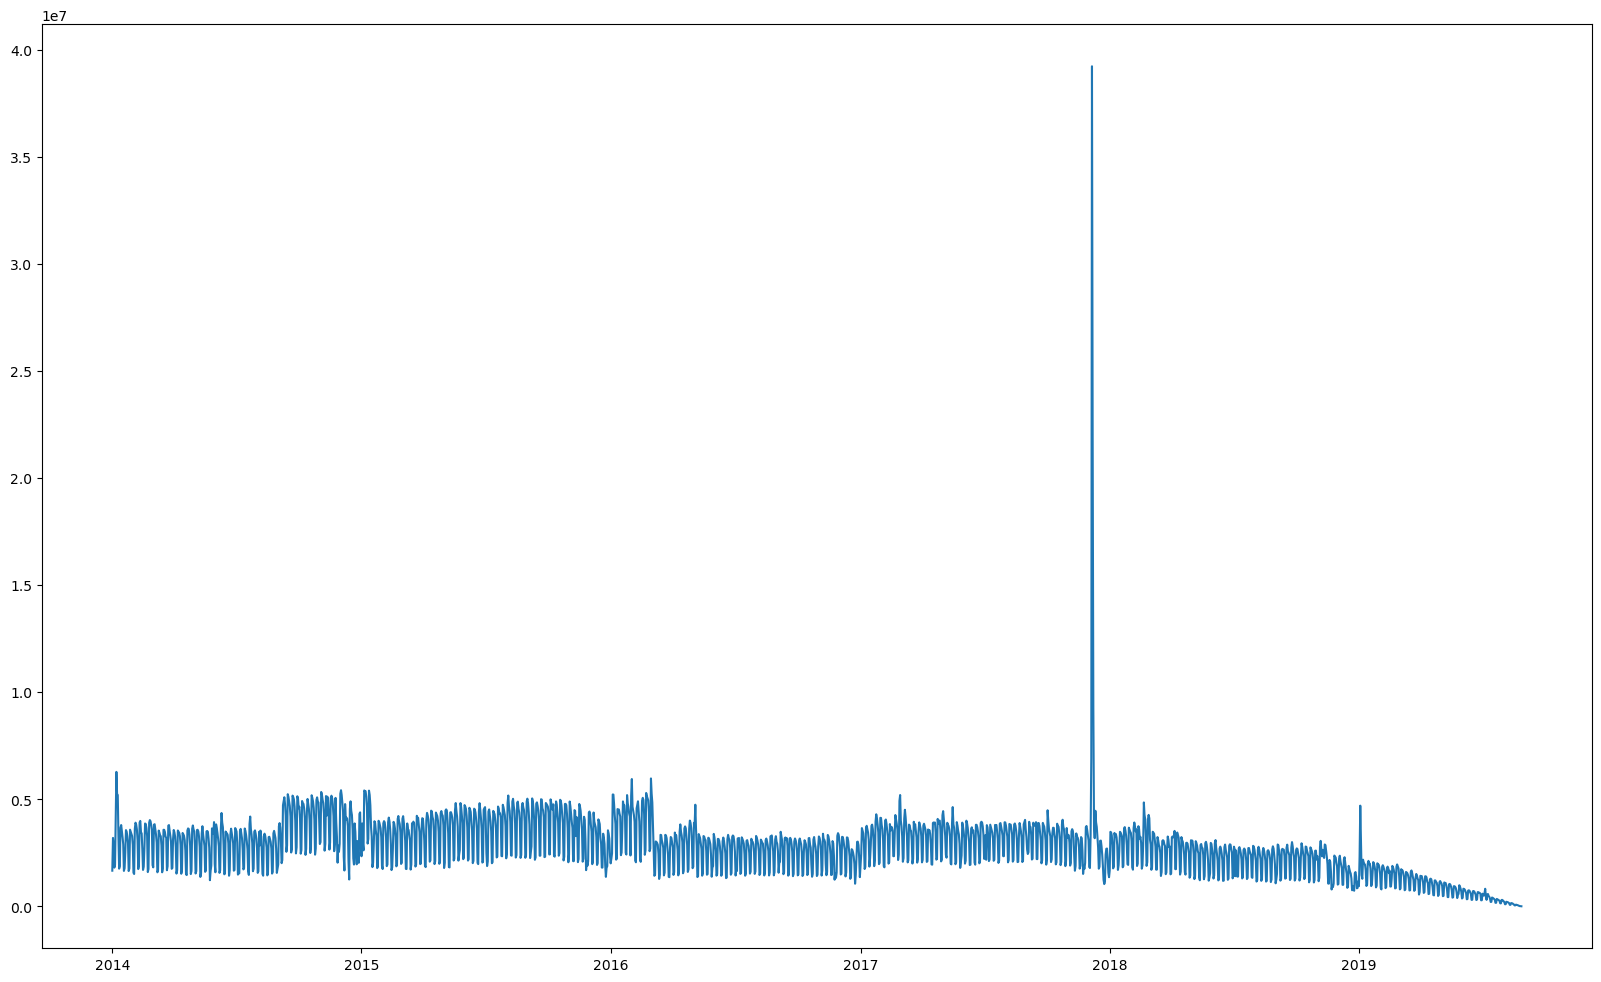

In [5]:
fig = plt.figure(figsize=(20,12))
plt.plot(df1)
plt.show()

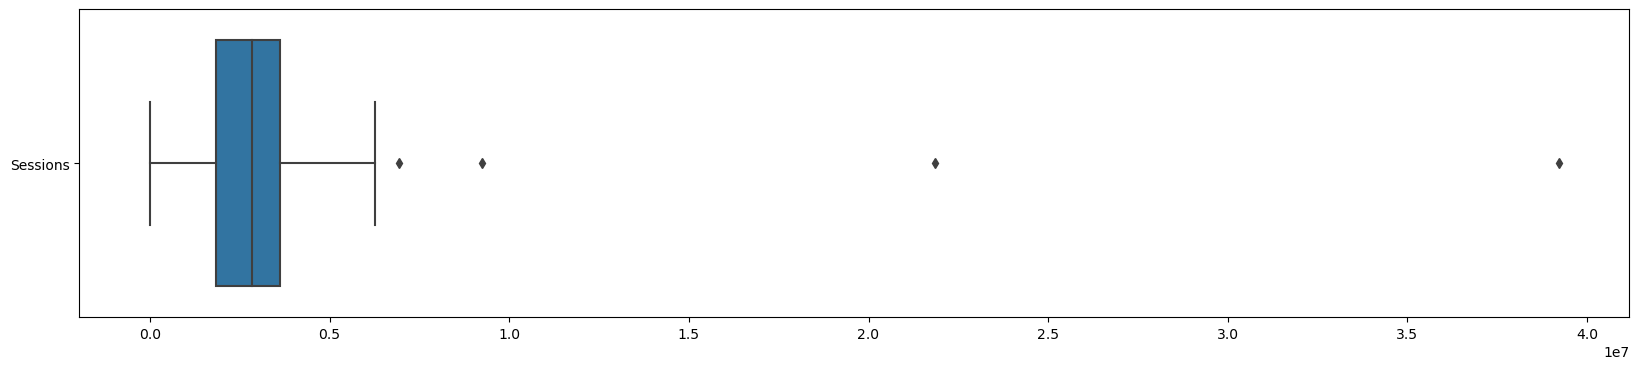

In [6]:
fig = plt.figure(figsize=(20,4))
sns.boxplot(df1, orient='h')
plt.show()

In [7]:
Q1 = np.percentile(df1, 25)
Q3 = np.percentile(df1, 75)
IQR = Q3 - Q1

L = Q1 - 1.5 * IQR
U = Q3 + 1.5 * IQR

df1['Outlier'] = ((df1['Sessions'] < L) | (df1['Sessions'] > U))
df1.loc[df1['Outlier'] == True]


Sessions  Outlier
Date                         
2017-12-05   6934804     True
2017-12-06  39217826     True
2017-12-07  21842773     True
2017-12-08   9250668     True

In [8]:
mean_sessions = df1.loc[df1['Outlier'] == False, 'Sessions'].mean()
df1.loc[df1['Outlier'] == True, 'Sessions'] = mean_sessions

df1 = df1.drop(columns=['Outlier'])


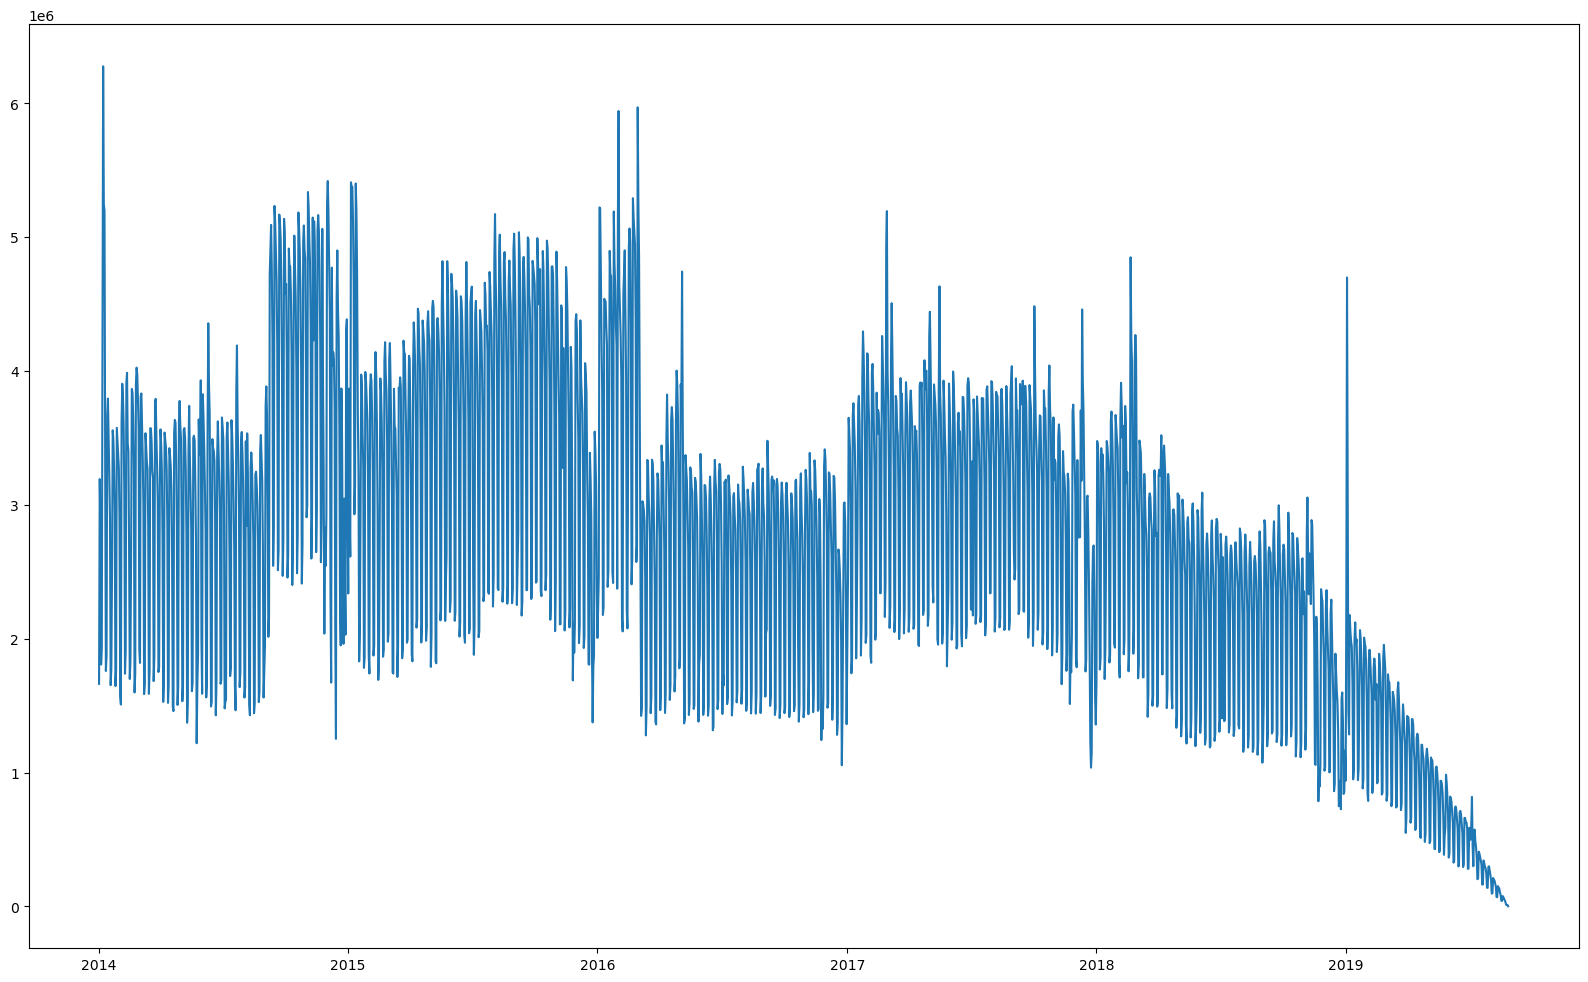

In [9]:
fig = plt.figure(figsize=(20, 12))
plt.plot(df1)
plt.show()


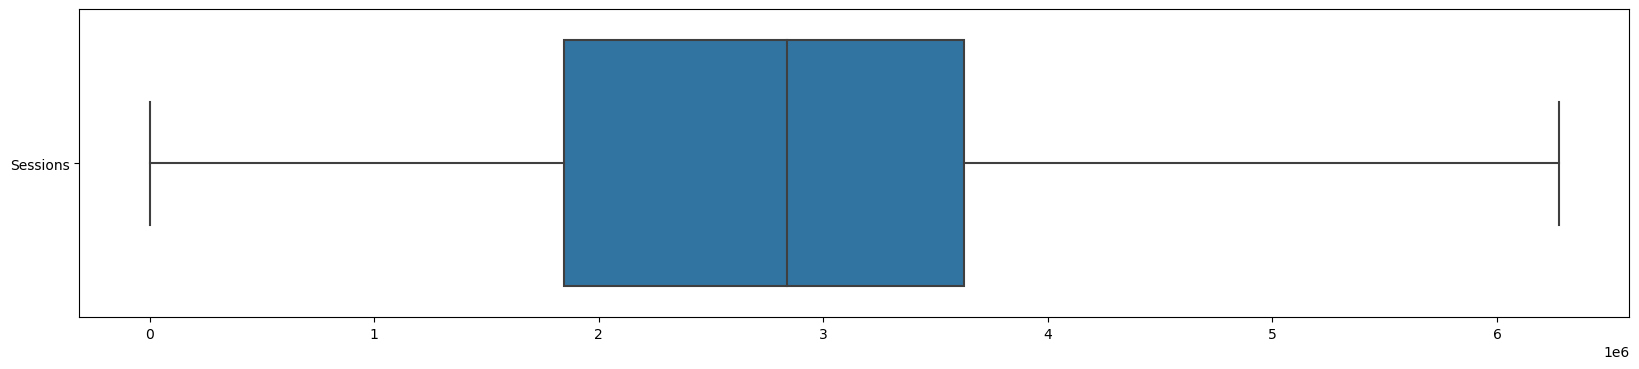

In [10]:
fig = plt.figure(figsize=(20, 4))
sns.boxplot(df1, orient='h')
plt.show()


# Stationarity tests


Decomposition of the endogenous variable: "Sessions"


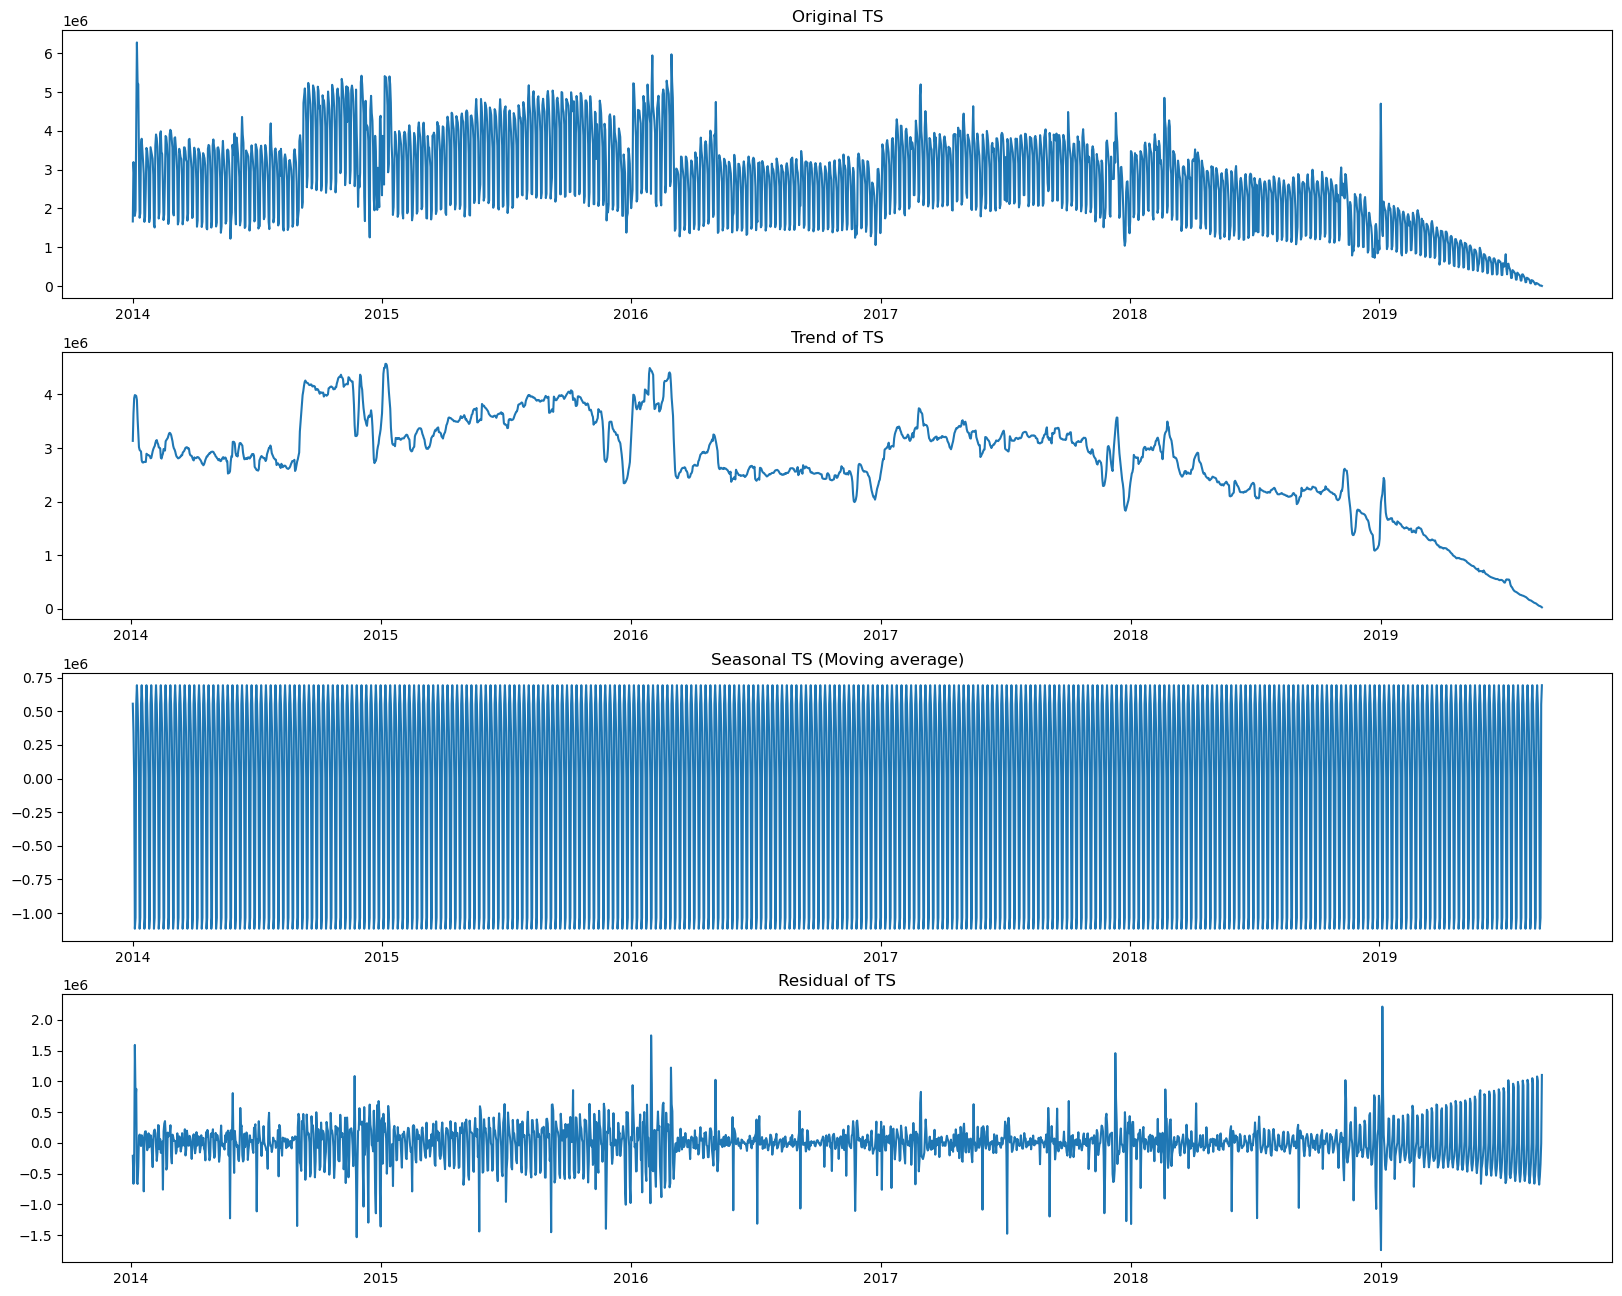

In [11]:
decomp = seasonal_decompose(df1['Sessions'])
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

fig = plt.figure(figsize=(20, 16))
plt.subplot(411)
plt.plot(df1['Sessions'])
plt.title('Original TS')

plt.subplot(412)
plt.plot(trend)
plt.title('Trend of TS')

plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonal TS (Moving average)')

plt.subplot(414)
plt.plot(resid)
plt.title('Residual of TS')

print('\nDecomposition of the endogenous variable: "Sessions"')


Text(0.5, 1.0, 'Original TS')

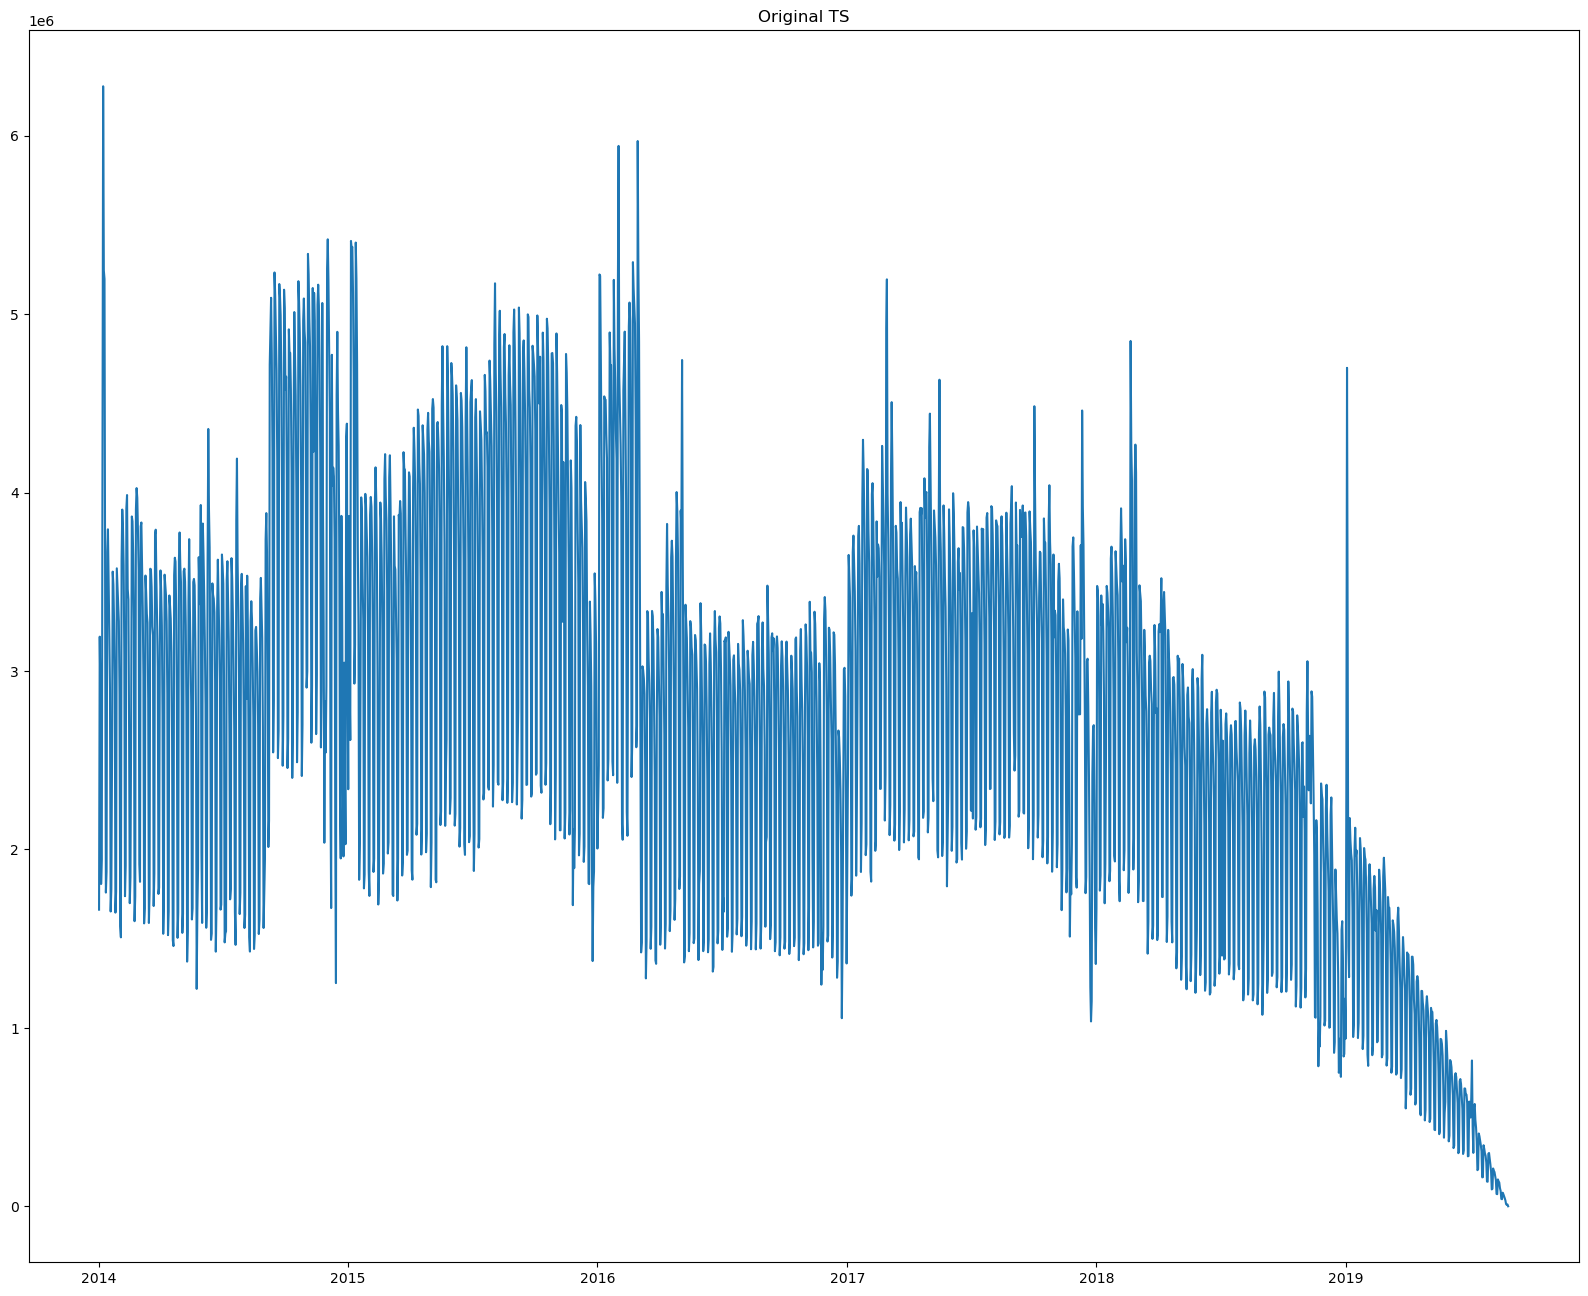

In [12]:
fig = plt.figure(figsize=(20,16))
plt.plot(df1['Sessions'])
plt.title('Original TS')

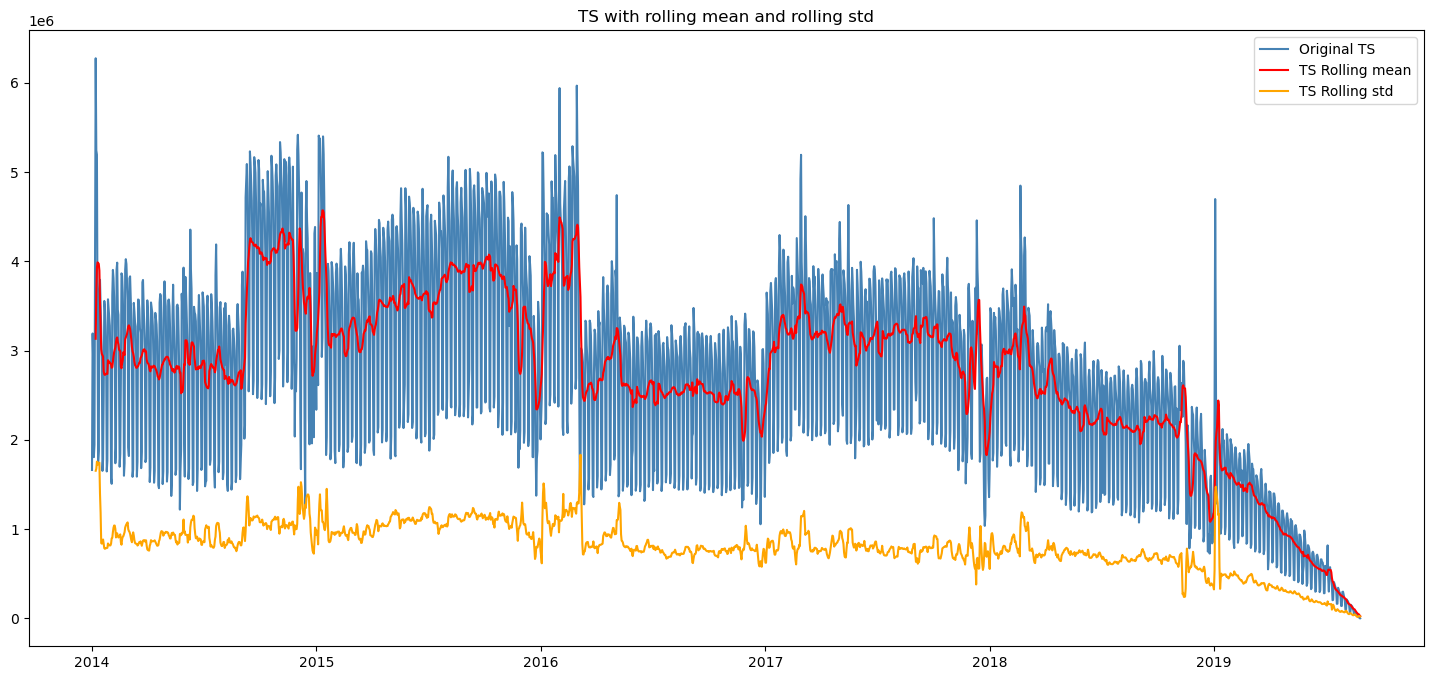

Results of the Augmented Dickey-Fuller test
Test stat.                -0.160682
p-value                    0.943049
#Lags chosen              26.000000
Total # observations    2038.000000
dtype: float64
Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.


In [13]:
def test_stationarity(timeseries, ssn_period: int, alpha: float = 0.05):
    # calculate rolling statistics
    rol_mean = timeseries.rolling(window=ssn_period).mean()
    rol_std = timeseries.rolling(window=ssn_period).std()
    
    # plot the ts and rolling metrics
    fig = plt.figure(figsize=(18,8))
    plt.plot(timeseries, color='steelblue', label='Original TS')
    plt.plot(rol_mean, color='red', label='TS Rolling mean')
    plt.plot(rol_std, color='orange', label='TS Rolling std')
    plt.legend(loc='best')
    plt.title("TS with rolling mean and rolling std")
    plt.show()

    print("Results of the Augmented Dickey-Fuller test")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test stat.', 'p-value', '#Lags chosen', 'Total # observations'])
    print(dfoutput)
    if dfoutput['p-value'] > alpha:
        print("Fail to reject Null-hypothesis (H0 accepted) -> Timeseries is NOT stationary.")
    else:
        print("Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.")

# Test the function with df1
test_stationarity(df1['Sessions'], 7, 0.05)


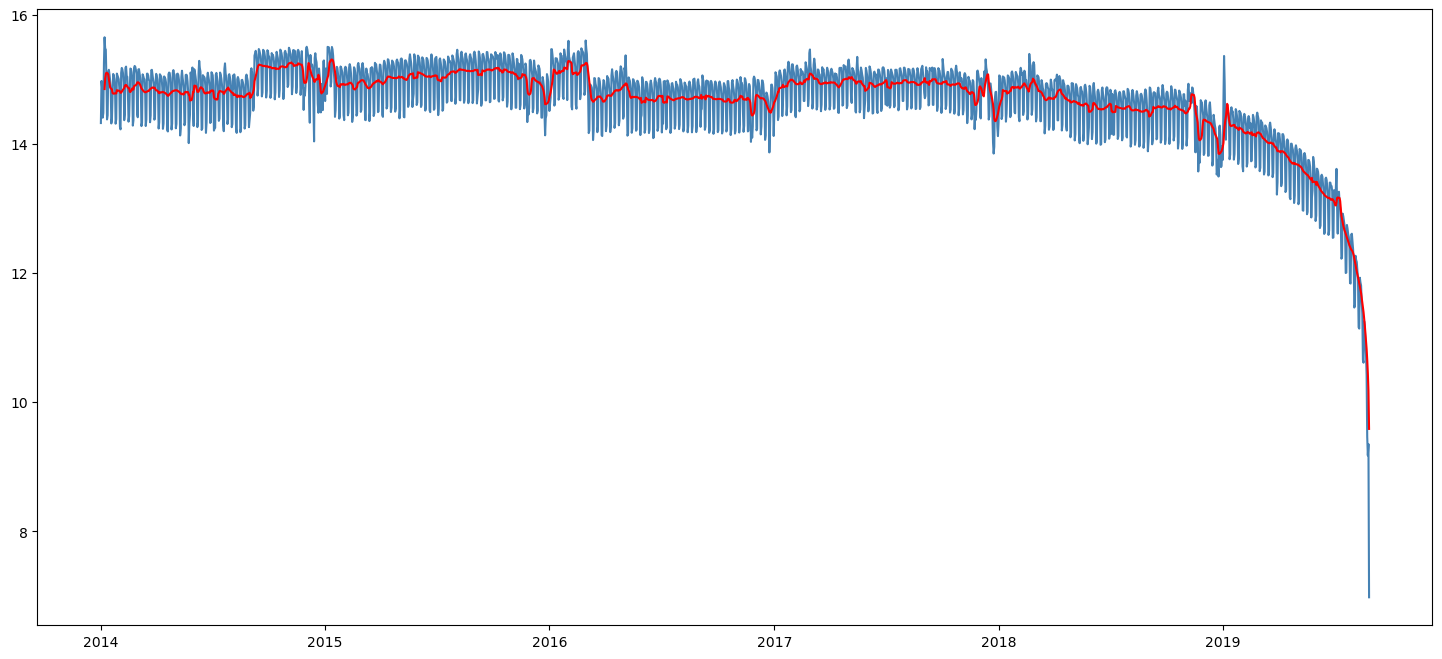

In [14]:
df1_log = np.log(df1)

moving_avg = df1_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18, 8))
plt.plot(df1_log, color='steelblue')
plt.plot(moving_avg, color='red')


In [15]:
df1_log = df1_log[df1_log.index <= '2018-10-01']


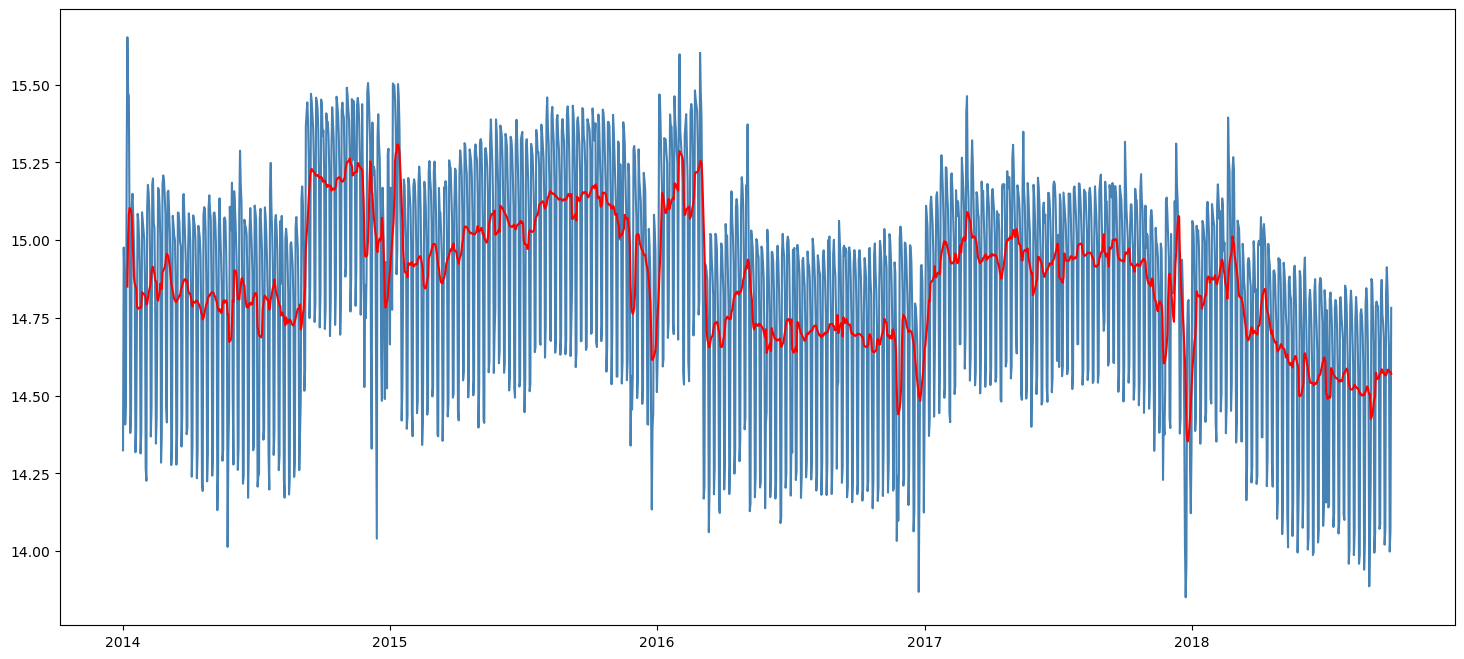

In [16]:
moving_avg = df1_log.rolling(window=7).mean()

fig = plt.figure(figsize=(18, 8))
plt.plot(df1_log, color='steelblue')
plt.plot(moving_avg, color='red')


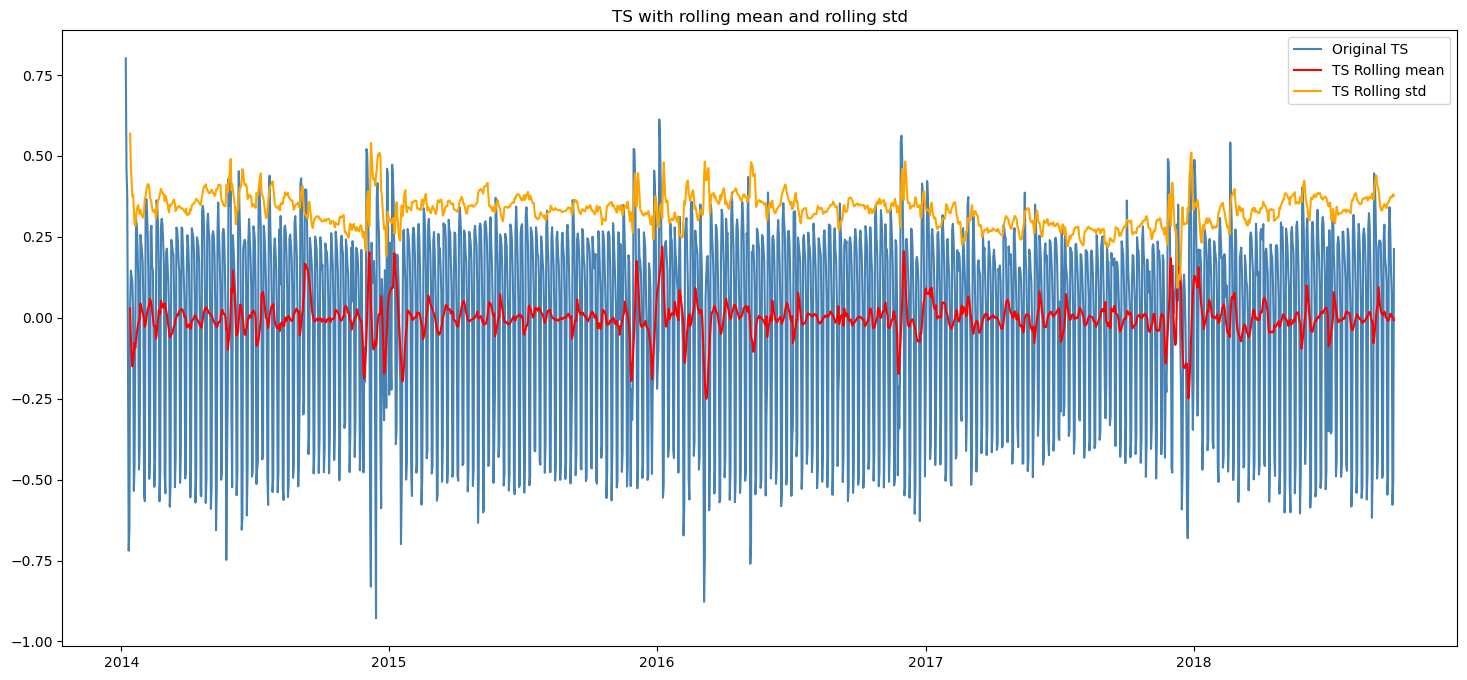

Results of the Augmented Dickey-Fuller test
Test stat.             -1.248396e+01
p-value                 3.047769e-23
#Lags chosen            2.300000e+01
Total # observations    1.705000e+03
dtype: float64
Rejection of Null-hypothesis (H0 rejected) -> Timeseries is stationary.


In [17]:
df1_log_moving_mean_diff = df1_log - moving_avg

df1_log_moving_mean_diff.dropna(inplace=True)

test_stationarity(df1_log_moving_mean_diff, 7, 0.05)


In [18]:
df1_log.to_csv('df1_final.csv')


The initial stationarity test failed, so I applied a logarithmic transformation and performed additional steps to make the data stationary.

In [19]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Time-series Forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')


In [20]:
df2 = pd.read_csv(r'C:\Users\lenovo1\Desktop\Time Series Forecasting\df1_final.csv', index_col=0, parse_dates=['Date'])
df2


Sessions
Date                 
2014-01-01  14.324045
2014-01-02  14.976250
2014-01-03  14.864884
2014-01-04  14.406985
2014-01-05  14.481084
...               ...
2018-09-27  14.729266
2018-09-28  14.654276
2018-09-29  13.998475
2018-09-30  14.066159
2018-10-01  14.782153

[1735 rows x 1 columns]

In [21]:
train_total = df2.loc[df2.index <  pd.Timestamp('2018-04-01')]
test_total  = df2.loc[df2.index >= pd.Timestamp('2018-04-01')]

# 1.EXPONENTIAL SMOOTHING

Train data shape: (1551, 1)
Test data shape: (184, 1)

Train / Test Split: 89.39% / 10.61%


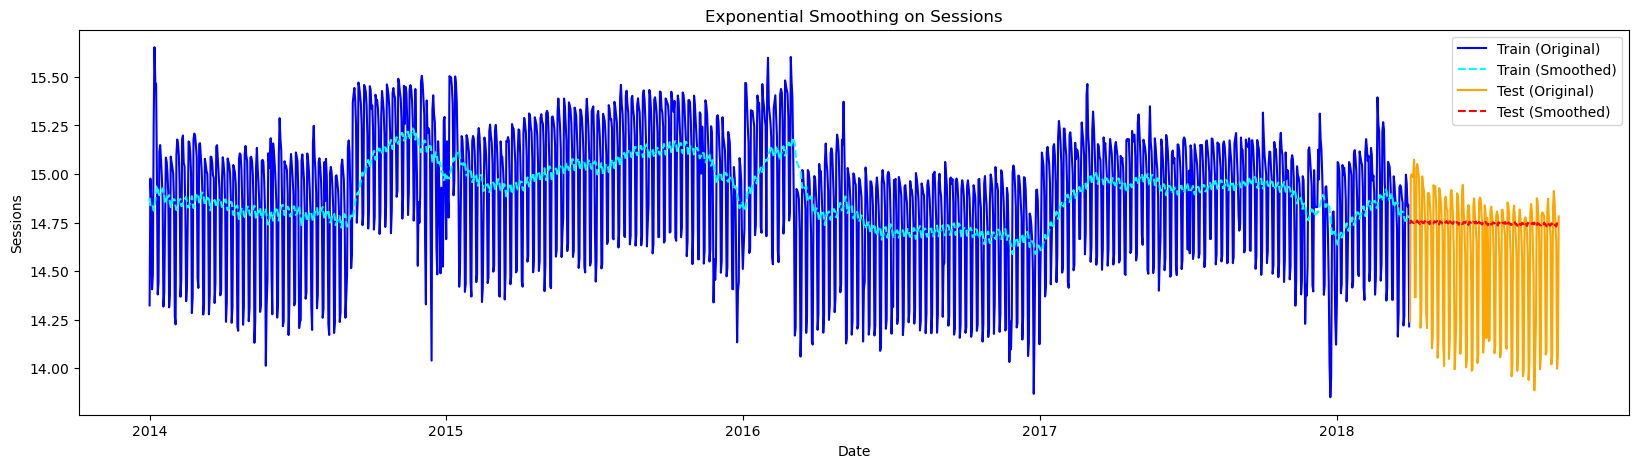

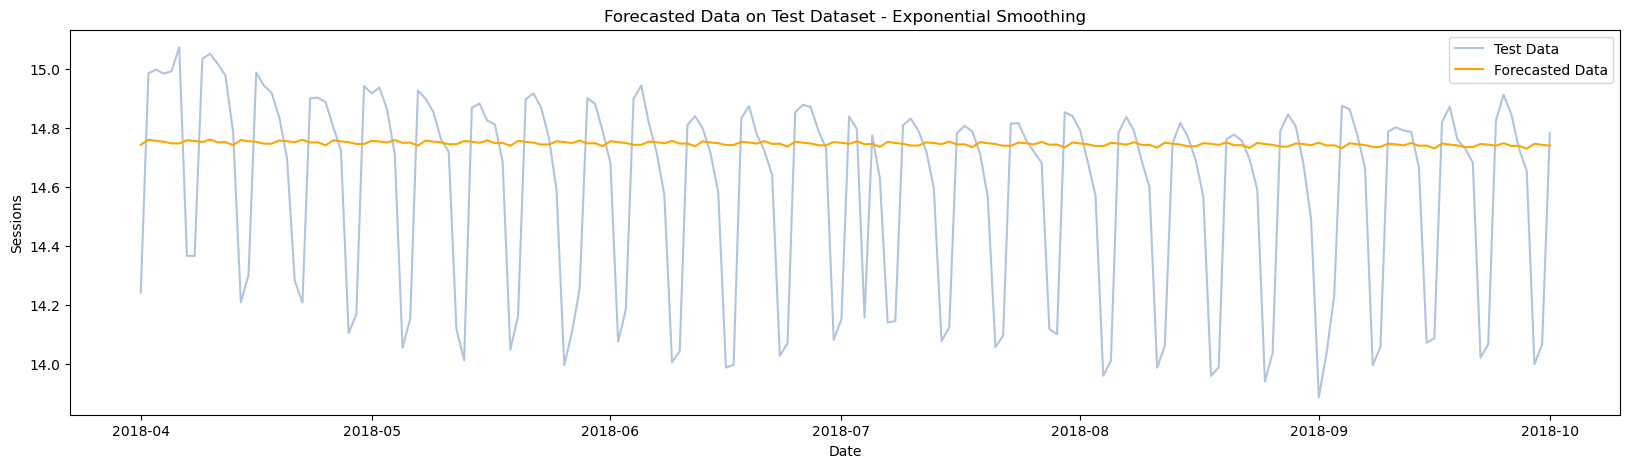

Performance metrics for Exponential Smoothing:
----------------------------------------------
MAE:    0.27
RMSE:   0.38
R2:     -22.43 %
MAPE:   1.88 %


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Split the dataset into training and testing sets
train_total = df2.loc[df2.index < pd.Timestamp('2018-04-01')]
test_total = df2.loc[df2.index >= pd.Timestamp('2018-04-01')]

train = train_total.shape[0]
test = test_total.shape[0]

print('Train data shape:', train_total.shape)
print('Test data shape:', test_total.shape)
print(f'\nTrain / Test Split: {round(train/(train + test)*100, 2)}% / {round(test/(train + test)*100, 2)}%')

# Apply Exponential Smoothing on 'Sessions'
model = ExponentialSmoothing(
    train_total['Sessions'],  # Use the Sessions column
    trend='add',  # Specify the trend component (additive)
    seasonal='add',  # Specify the seasonal component (additive)
    seasonal_periods=12  # Define the seasonal period (e.g., 12 months if monthly data)
)
fitted_model = model.fit()

# Generate smoothed predictions for training and testing sets
train_smoothed = fitted_model.fittedvalues
test_smoothed = fitted_model.forecast(len(test_total))

# Plotting the entire dataset with the forecasted data
plt.figure(figsize=[20, 5])
plt.plot(train_total.index, train_total['Sessions'], label='Train (Original)', color='blue')
plt.plot(train_total.index, train_smoothed, label='Train (Smoothed)', color='cyan', linestyle='--')
plt.plot(test_total.index, test_total['Sessions'], label='Test (Original)', color='orange')
plt.plot(test_total.index, test_smoothed, label='Test (Smoothed)', color='red', linestyle='--')
plt.legend()
plt.title('Exponential Smoothing on Sessions')
plt.xlabel('Date')
plt.ylabel('Sessions')
plt.show()

# Plotting only the test dataset with the forecasted data
plt.figure(figsize=[20, 5])
plt.plot(test_total.index, test_total['Sessions'], label='Test Data', color='lightsteelblue')
plt.plot(test_total.index, test_smoothed, label='Forecasted Data', color='orange')
plt.title('Forecasted Data on Test Dataset - Exponential Smoothing')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sessions')
plt.show()

# Evaluate the performance on the test set
mae = mean_absolute_error(test_total['Sessions'], test_smoothed)
rmse = mean_squared_error(test_total['Sessions'], test_smoothed, squared=False)
r2 = r2_score(test_total['Sessions'], test_smoothed)
mape = mean_absolute_percentage_error(test_total['Sessions'], test_smoothed)

print('Performance metrics for Exponential Smoothing:')
print('----------------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2 * 100, 2), '%')
print('MAPE:  ', round(mape * 100, 2), '%')


Train shape: (1551, 1)
Test shape: (184, 1)

Train / Test -> 89.39% / 10.61%
p = 0, with MAPE = 2.34%
p = 1, with MAPE = 2.35%
p = 2, with MAPE = 2.32%
p = 3, with MAPE = 2.32%
p = 4, with MAPE = 2.32%
p = 5, with MAPE = 2.31%
p = 6, with MAPE = 2.22%
p = 7, with MAPE = 2.01%
p = 8, with MAPE = 2.05%
p = 9, with MAPE = 2.09%
p = 10, with MAPE = 2.1%
p = 11, with MAPE = 2.09%
p = 12, with MAPE = 2.08%
p = 13, with MAPE = 2.01%
p = 14, with MAPE = 1.85%
-------------------------------------------------
Best model:
p -> 14 with MAPE = 1.85%
                            AutoReg Model Results                             
Dep. Variable:               Sessions   No. Observations:                 1551
Model:                    AutoReg(14)   Log Likelihood                 925.882
Method:               Conditional MLE   S.D. of innovations              0.132
Date:                Sun, 29 Dec 2024   AIC                          -1819.764
Time:                        15:04:44   BIC                  

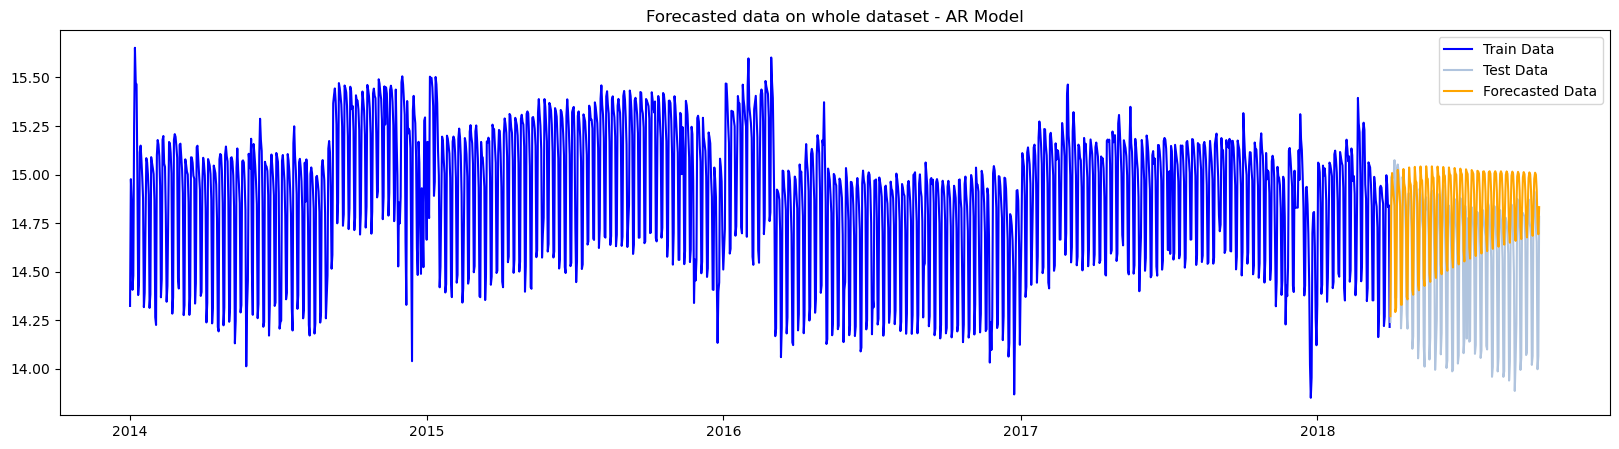

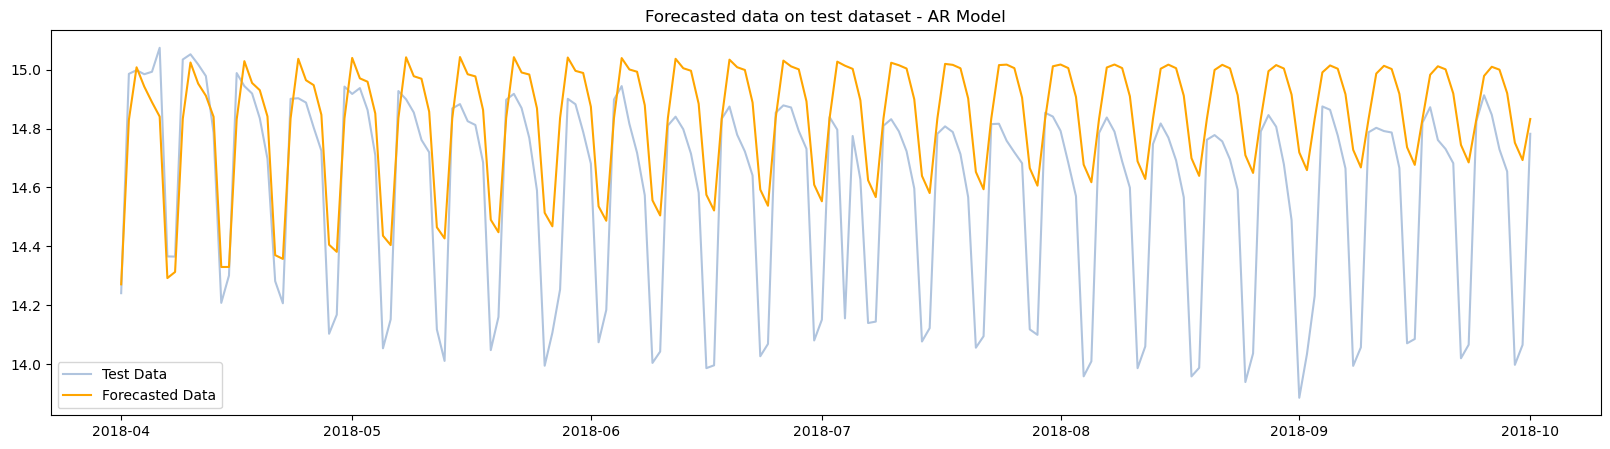

In [33]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Splitting the dataset
train_total = df2.loc[df2.index < pd.Timestamp('2018-04-01')]
test_total = df2.loc[df2.index >= pd.Timestamp('2018-04-01')]

print('Train shape:', train_total.shape)
print('Test shape:', test_total.shape)

train = train_total.shape[0]
test = test_total.shape[0]
print(f'\nTrain / Test -> {round(train / (train + test) * 100, 2)}% / {round(test / (train + test) * 100, 2)}%')

# Generate all combinations of p (lags) for AR model
p = range(0, 15)  # Trying lag values from 0 to 14
best_mape = float('inf')
best_p = None

# Iterate over possible p values
for p_value in p:
    # Fit the AR model
    model_AR = AutoReg(train_total['Sessions'], lags=p_value)
    results = model_AR.fit()

    # Forecasting
    forecast = results.predict(start=test_total.index[0], end=test_total.index[-1])

    # Calculate MAPE
    mape = mean_absolute_percentage_error(test_total['Sessions'], forecast)
    print(f'p = {p_value}, with MAPE = {round(mape * 100, 2)}%')

    if mape < best_mape:
        best_mape = mape
        best_p = p_value

print('-------------------------------------------------')
print('Best model:')
print(f'p -> {best_p} with MAPE = {round(best_mape * 100, 2)}%')

# Fit the best AR model
model_AR_best = AutoReg(train_total['Sessions'], lags=best_p)
results_best = model_AR_best.fit()
print(results_best.summary())

# Forecast and evaluate
forecast_best = results_best.predict(start=test_total.index[0], end=test_total.index[-1])
y_test = test_total['Sessions']
y_pred = forecast_best

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Performance metrics for AR model:')
print('-----------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2 * 100, 2), '%')
print('MAPE:  ', round(mape * 100, 2), '%')

# Plotting
Train = train_total['Sessions']
Test = test_total['Sessions']
Forecast = forecast_best

plt.figure(figsize=[20, 5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forecasted data on whole dataset - AR Model')
plt.legend()
plt.show()

plt.figure(figsize=[20, 5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forecasted data on test dataset - AR Model')
plt.legend()
plt.show()


# 3.MOVING AVERAGE

Train data shape: (1551, 1)
Test data shape: (184, 1)

Train / Test Split: 89.39% / 10.61%


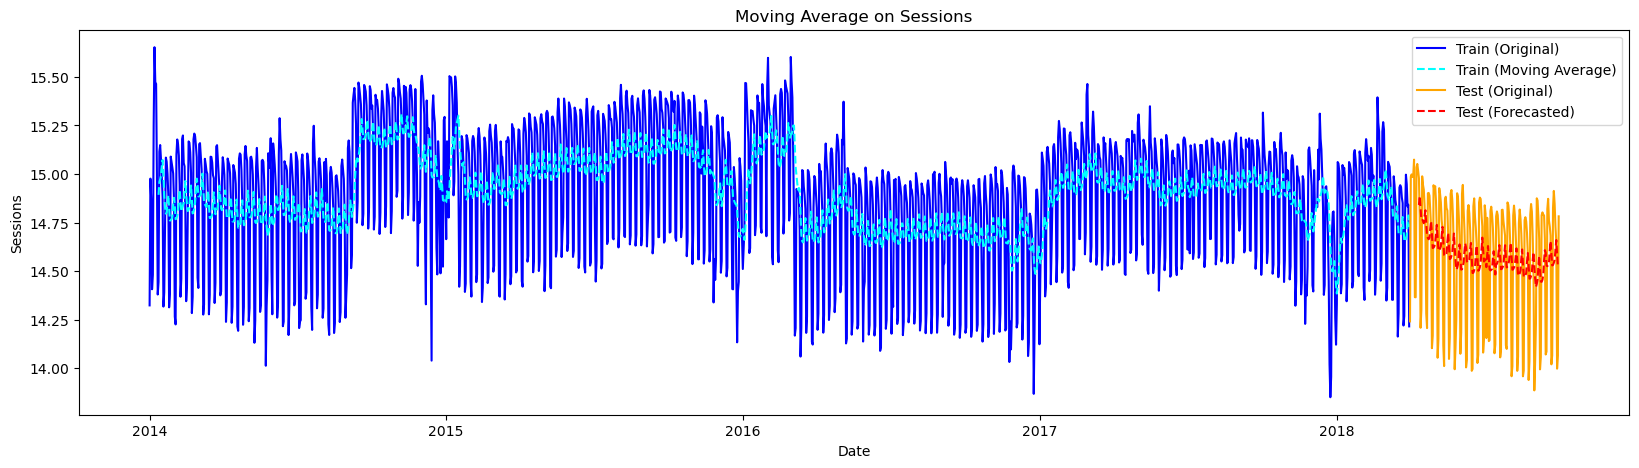

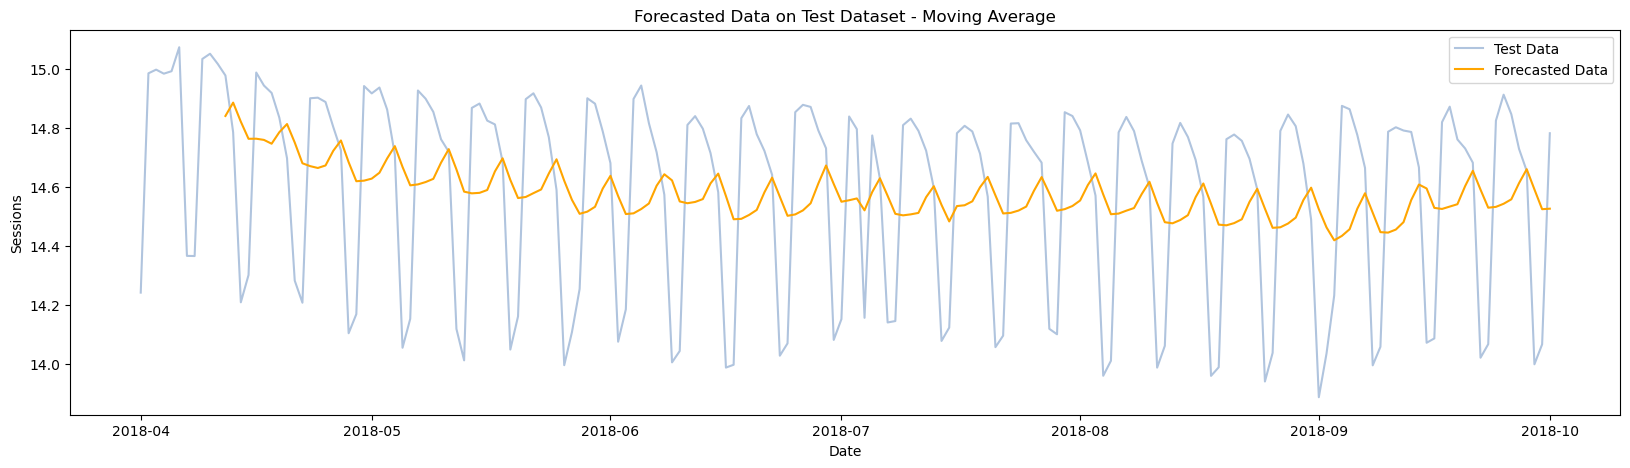

Performance metrics for Moving Average:
----------------------------------------------
MAE:    0.3
RMSE:   0.34
R2:     -0.03 %
MAPE:   2.07 %


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Check and handle missing values in the dataset
if df2['Sessions'].isna().sum() > 0:
    print("Handling missing values in the 'Sessions' column...")
    df2['Sessions'] = df2['Sessions'].fillna(method='ffill')  # Forward fill as default handling
    df2['Sessions'] = df2['Sessions'].fillna(method='bfill')  # Backward fill for remaining NaNs

# Split the dataset into training and testing sets
train_total = df2.loc[df2.index < pd.Timestamp('2018-04-01')]
test_total = df2.loc[df2.index >= pd.Timestamp('2018-04-01')]

train = train_total.shape[0]
test = test_total.shape[0]

print('Train data shape:', train_total.shape)
print('Test data shape:', test_total.shape)
print(f'\nTrain / Test Split: {round(train / (train + test) * 100, 2)}% / {round(test / (train + test) * 100, 2)}%')

# Use a simple moving average for forecasting
window_size = 12  # Define the window size (e.g., 12 months for seasonal data)

# Apply rolling mean on 'Sessions'
train_total['SMA'] = train_total['Sessions'].rolling(window=window_size).mean()

# Generate moving average forecast for the test set
test_smoothed = test_total['Sessions'].rolling(window=window_size).mean()

# Plotting the entire dataset with the forecasted data
plt.figure(figsize=[20, 5])
plt.plot(train_total.index, train_total['Sessions'], label='Train (Original)', color='blue')
plt.plot(train_total.index, train_total['SMA'], label='Train (Moving Average)', color='cyan', linestyle='--')
plt.plot(test_total.index, test_total['Sessions'], label='Test (Original)', color='orange')
plt.plot(test_total.index, test_smoothed, label='Test (Forecasted)', color='red', linestyle='--')
plt.legend()
plt.title('Moving Average on Sessions')
plt.xlabel('Date')
plt.ylabel('Sessions')
plt.show()

# Plotting only the test dataset with the forecasted data
plt.figure(figsize=[20, 5])
plt.plot(test_total.index, test_total['Sessions'], label='Test Data', color='lightsteelblue')
plt.plot(test_total.index, test_smoothed, label='Forecasted Data', color='orange')
plt.title('Forecasted Data on Test Dataset - Moving Average')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sessions')
plt.show()

# Evaluate the performance on the test set
# Replace NaNs in the test_smoothed series with the mean of actual test values
test_smoothed = test_smoothed.fillna(test_total['Sessions'].mean())

mae = mean_absolute_error(test_total['Sessions'], test_smoothed)
rmse = mean_squared_error(test_total['Sessions'], test_smoothed, squared=False)
r2 = r2_score(test_total['Sessions'], test_smoothed)
mape = mean_absolute_percentage_error(test_total['Sessions'], test_smoothed)

print('Performance metrics for Moving Average:')
print('----------------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2 * 100, 2), '%')
print('MAPE:  ', round(mape * 100, 2), '%')


# 4.ARIMA

In [38]:
# Generate all different combinations of p, q and q triplets

p = range(0, 15)
d = range(0, 4)
q = range(0, 4)

pdq = list(itertools.product(p, d, q))

In [39]:
best_mape = float('inf')
best_order = None

for order in pdq:
    p, d, q = order
    model_ARIMA = ARIMA(train_total['Sessions'],
                  exog=None,
                  order=(p, d, q),
                  seasonal_order=(0, 0, 0, 0), 
                  trend=None, 
                  enforce_stationarity=True, 
                  freq='1D')

    
    results = model_ARIMA.fit()
    results = results.forecast(steps=len(test_total))
    
    mape = mean_absolute_percentage_error(test_total['Sessions'], results)
    print(f'(p, d, q) order: {order}, with MAPE = {round(mape*100, 2)}%')

    if mape < best_mape:
        best_mape = mape
        best_order = order
        
print('-------------------------------------------------')
print('Best model:')
print(f'(p, d, q) -> {best_order} with MAPE = {round(best_mape*100, 2)}%')


(p, d, q) order: (0, 0, 0), with MAPE = 2.34%
(p, d, q) order: (0, 0, 1), with MAPE = 2.32%
(p, d, q) order: (0, 0, 2), with MAPE = 2.32%
(p, d, q) order: (0, 0, 3), with MAPE = 2.33%
(p, d, q) order: (0, 1, 0), with MAPE = 3.04%
(p, d, q) order: (0, 1, 1), with MAPE = 3.88%
(p, d, q) order: (0, 1, 2), with MAPE = 1.88%
(p, d, q) order: (0, 1, 3), with MAPE = 1.88%
(p, d, q) order: (0, 2, 0), with MAPE = 400.7%
(p, d, q) order: (0, 2, 1), with MAPE = 3.06%
(p, d, q) order: (0, 2, 2), with MAPE = 3.92%
(p, d, q) order: (0, 2, 3), with MAPE = 1.87%
(p, d, q) order: (0, 3, 0), with MAPE = 25464.13%
(p, d, q) order: (0, 3, 1), with MAPE = 433.27%
(p, d, q) order: (0, 3, 2), with MAPE = 9.42%
(p, d, q) order: (0, 3, 3), with MAPE = 60.29%
(p, d, q) order: (1, 0, 0), with MAPE = 2.34%
(p, d, q) order: (1, 0, 1), with MAPE = 2.32%
(p, d, q) order: (1, 0, 2), with MAPE = 2.32%
(p, d, q) order: (1, 0, 3), with MAPE = 2.33%
(p, d, q) order: (1, 1, 0), with MAPE = 3.26%
(p, d, q) order: (1, 1, 1)

In [40]:
model_ARIMA = ARIMA(train_total['Sessions'],
              exog=None,
              order = (best_order[0], best_order[1], best_order[2]),
              seasonal_order=(0, 0, 0, 0), 
              trend=None, 
              enforce_stationarity=True, 
              freq='1D')

results = model_ARIMA.fit()
print(results.summary())

results = results.forecast(steps = len(test_total))

                               SARIMAX Results                                
Dep. Variable:               Sessions   No. Observations:                 1551
Model:                 ARIMA(7, 2, 2)   Log Likelihood                 619.937
Date:                Sun, 29 Dec 2024   AIC                          -1219.874
Time:                        15:32:50   BIC                          -1166.421
Sample:                    01-01-2014   HQIC                         -1199.993
                         - 03-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0172      0.049     -0.354      0.723      -0.112       0.078
ar.L2         -0.0453      0.048     -0.940      0.347      -0.140       0.049
ar.L3         -0.0083      0.050     -0.168      0.8

In [41]:
y_test = test_total['Sessions']
y_pred = results

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Preformance metrics for ARIMA model:')
print('--------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2*100, 2), '%')
print('MAPE:  ', round(mape*100, 2), '%')

Preformance metrics for ARIMA model:
--------------------------------------
MAE:    0.09
RMSE:   0.13
R2:     86.43 %
MAPE:   0.64 %


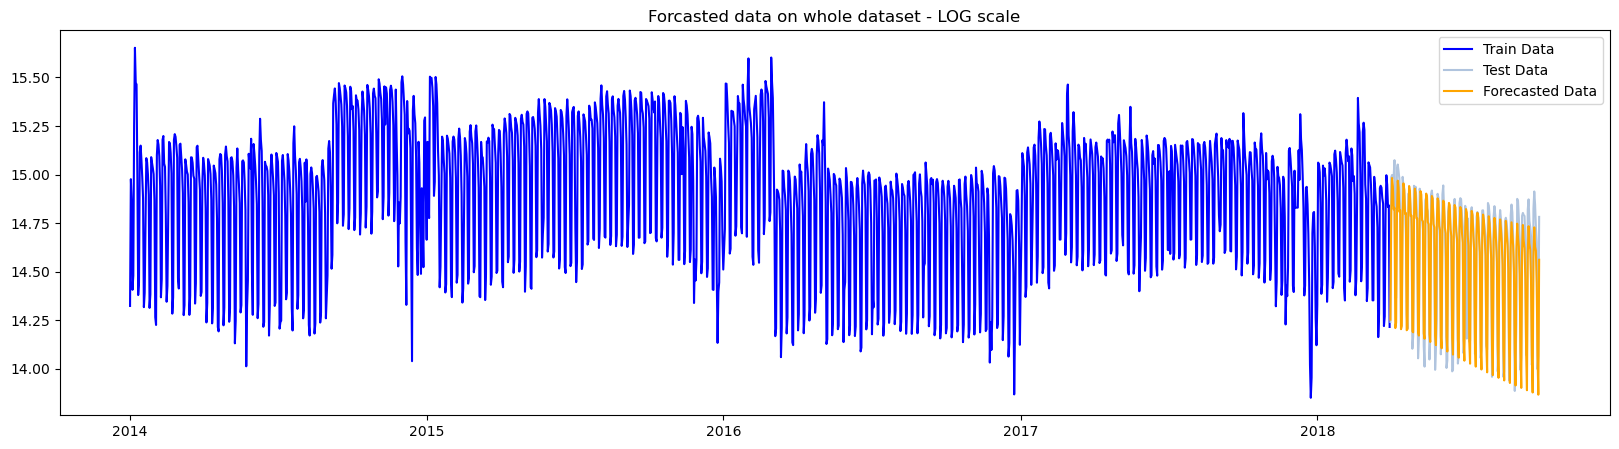

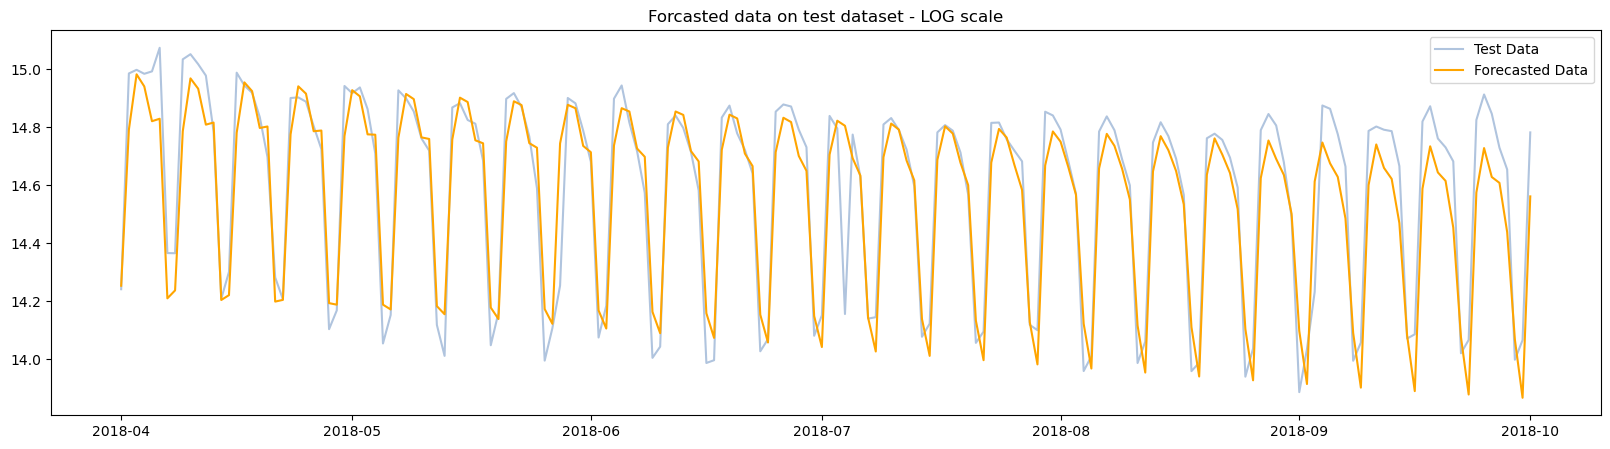

In [42]:
# Forcasted data in LOG scale

Train = train_total['Sessions']
Test = test_total['Sessions']
Forecast = results

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset - LOG scale')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset - LOG scale')
plt.legend()
plt.show()

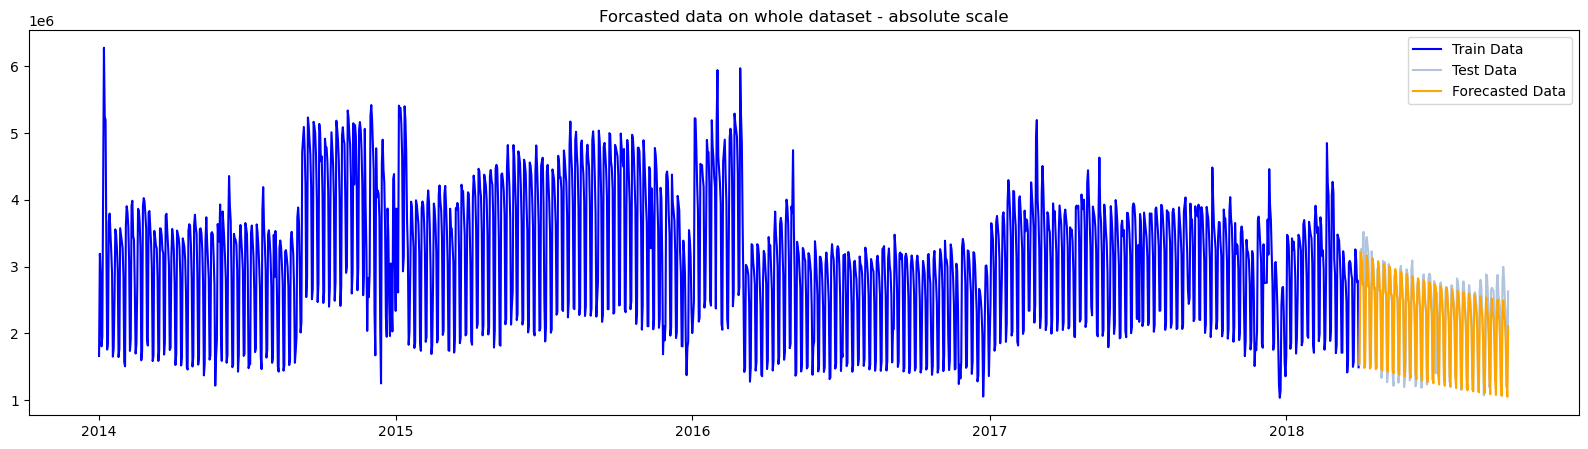

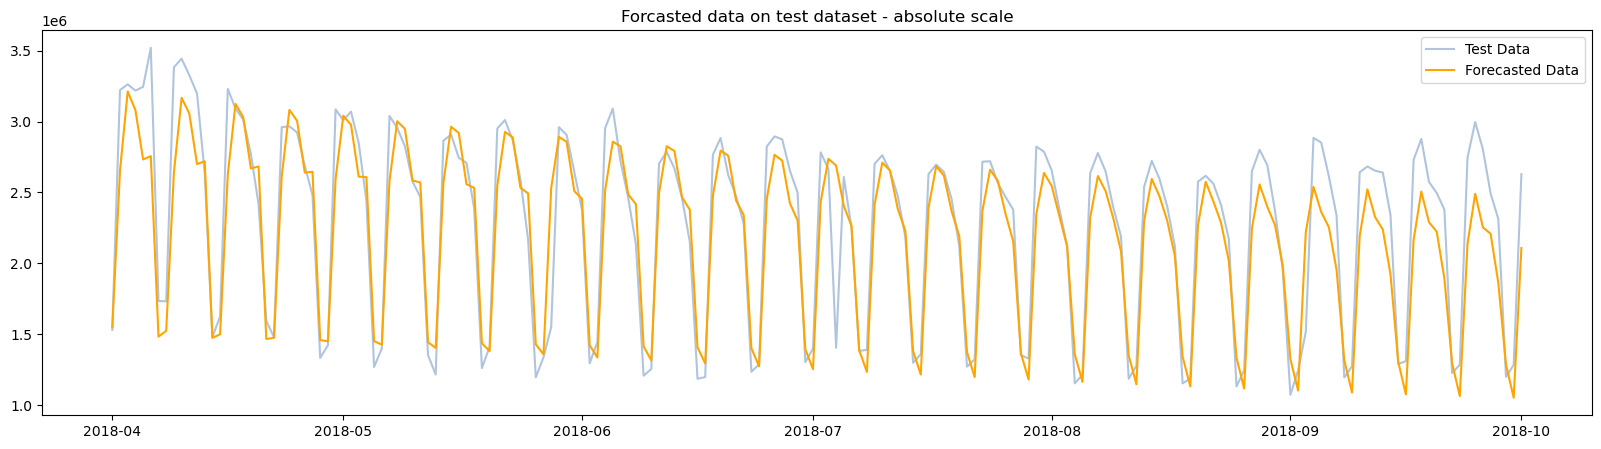

In [43]:
# Forcasted data in absolute scale

Train = np.exp(train_total['Sessions'])
Test = np.exp(test_total['Sessions'])
Forecast = np.exp(results)

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset - absolute scale')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset - absolute scale')
plt.legend()
plt.show()

# 5. SARIMA

In [44]:
best_mape = float('inf')
best_order = None

for order in pdq:
    p, d, q = order

    model_SARIMA = SARIMAX(train_total['Sessions'], 
                    exog=None,
                    order=(p, d, q),
                    seasonal_order=(0, 0, 0, 7),
                    trend=None,
                    enforce_stationarity=True,
                    enforce_invertibility=False, 
                    freq='1D')
    
    results = model_SARIMA.fit()
    results = results.forecast(steps=len(test_total))
   
    mape = mean_absolute_percentage_error(test_total['Sessions'], results)
    print(f'(p, d, q) order: {order}, with MAPE = {round(mape*100, 2)}%')

    if mape < best_mape:
        best_mape = mape
        best_order = order
        
print('-------------------------------------------------')
print('Best model:')
print(f'(p, d, q) -> {best_order} with MAPE = {round(best_mape*100, 2)}%')


(p, d, q) order: (0, 0, 0), with MAPE = 100.0%
(p, d, q) order: (0, 0, 1), with MAPE = 99.74%
(p, d, q) order: (0, 0, 2), with MAPE = 99.49%
(p, d, q) order: (0, 0, 3), with MAPE = 99.29%
(p, d, q) order: (0, 1, 0), with MAPE = 3.04%
(p, d, q) order: (0, 1, 1), with MAPE = 3.88%
(p, d, q) order: (0, 1, 2), with MAPE = 1.88%
(p, d, q) order: (0, 1, 3), with MAPE = 1.88%
(p, d, q) order: (0, 2, 0), with MAPE = 400.7%
(p, d, q) order: (0, 2, 1), with MAPE = 3.06%
(p, d, q) order: (0, 2, 2), with MAPE = 3.92%
(p, d, q) order: (0, 2, 3), with MAPE = 1.87%
(p, d, q) order: (0, 3, 0), with MAPE = 25464.13%
(p, d, q) order: (0, 3, 1), with MAPE = 433.27%
(p, d, q) order: (0, 3, 2), with MAPE = 7.26%
(p, d, q) order: (0, 3, 3), with MAPE = 6.25%
(p, d, q) order: (1, 0, 0), with MAPE = 4.86%
(p, d, q) order: (1, 0, 1), with MAPE = 7.02%
(p, d, q) order: (1, 0, 2), with MAPE = 1.87%
(p, d, q) order: (1, 0, 3), with MAPE = 1.88%
(p, d, q) order: (1, 1, 0), with MAPE = 3.26%
(p, d, q) order: (1, 1,

In [45]:
model_SARIMA = SARIMAX(train_total['Sessions'], 
                exog=None,
                order=(best_order[0], best_order[1], best_order[2]),
                seasonal_order=(0, 0, 0, 7),
                trend=None,
                enforce_stationarity=True,
                enforce_invertibility=False, 
                freq='1D')

results = model_SARIMA.fit()
print(results.summary())

results = results.forecast(steps = len(test_total))

                               SARIMAX Results                                
Dep. Variable:               Sessions   No. Observations:                 1551
Model:              SARIMAX(13, 2, 0)   Log Likelihood                 833.598
Date:                Sun, 29 Dec 2024   AIC                          -1639.196
Time:                        15:52:01   BIC                          -1564.361
Sample:                    01-01-2014   HQIC                         -1611.362
                         - 03-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2861      0.016    -82.134      0.000      -1.317      -1.255
ar.L2         -1.5038      0.026    -57.823      0.000      -1.555      -1.453
ar.L3         -1.6372      0.038    -42.556      0.0

In [46]:
y_test = test_total['Sessions']
y_pred = results

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print('Preformance metrics for SARIMA model:')
print('--------------------------------------')
print('MAE:   ', round(mae, 2))
print('RMSE:  ', round(rmse, 2))
print('R2:    ', round(r2*100, 2), '%')
print('MAPE:  ', round(mape*100, 2), '%')

Preformance metrics for SARIMA model:
--------------------------------------
MAE:    0.14
RMSE:   0.17
R2:     73.87 %
MAPE:   0.96 %


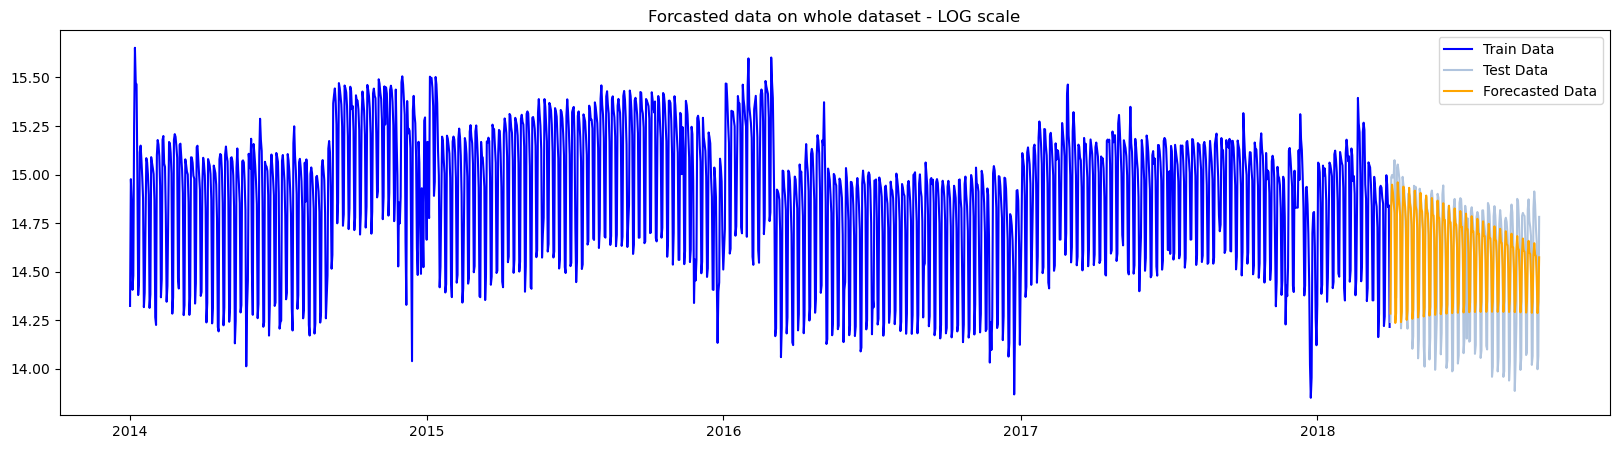

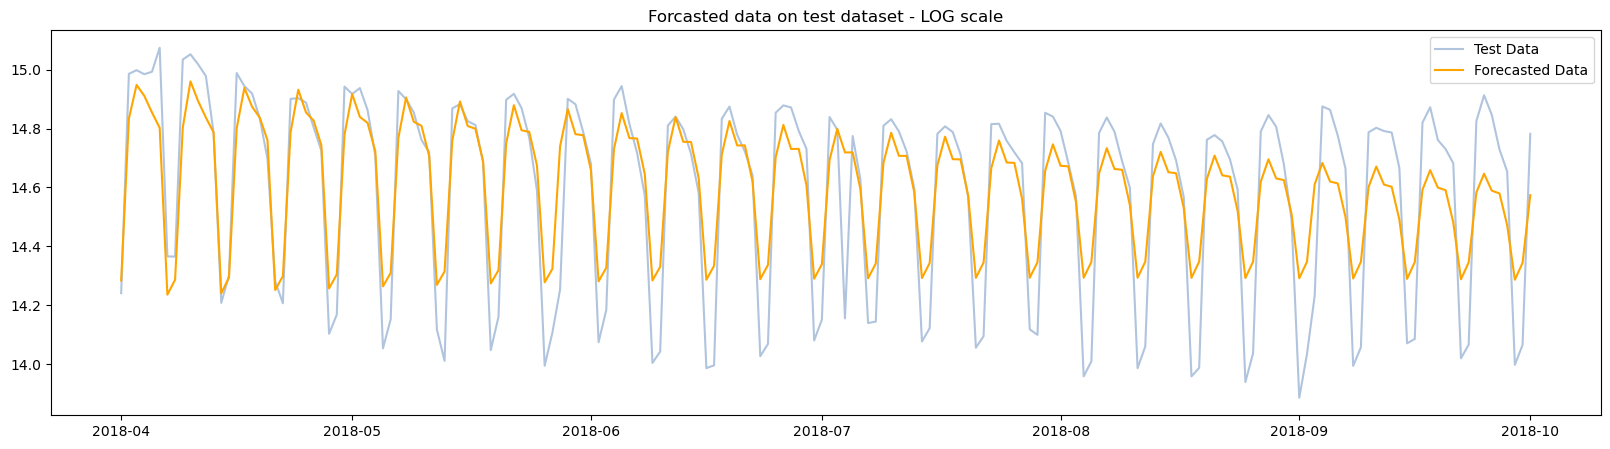

In [47]:
# Forcasted data in LOG scale

Train = train_total['Sessions']
Test = test_total['Sessions']
Forecast = results

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset - LOG scale')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset - LOG scale')
plt.legend()
plt.show()

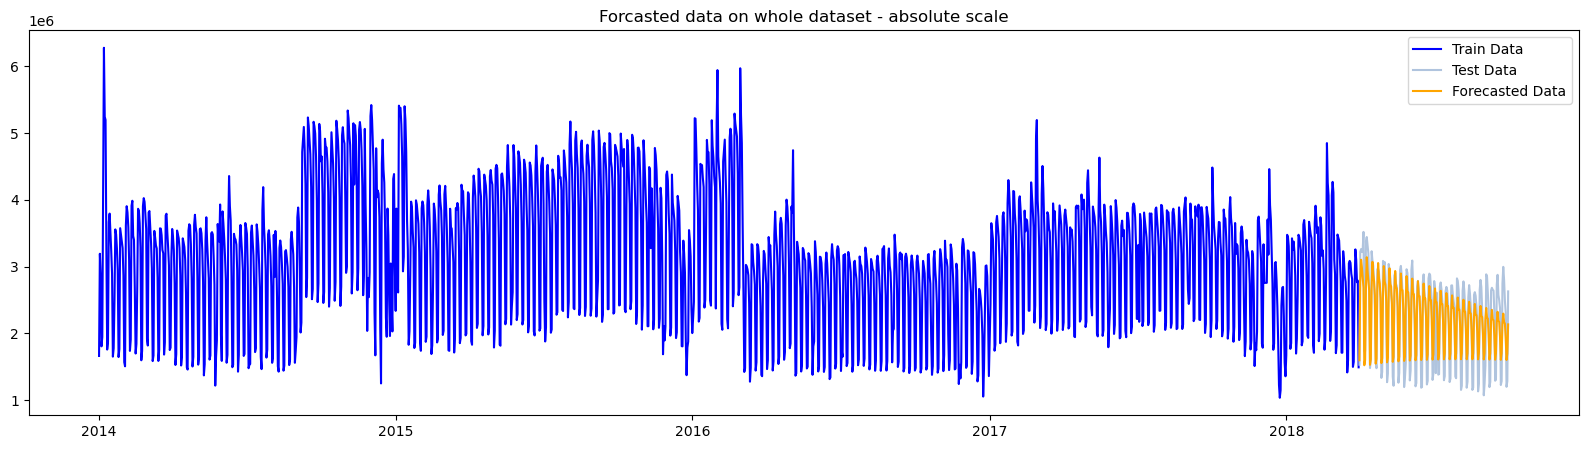

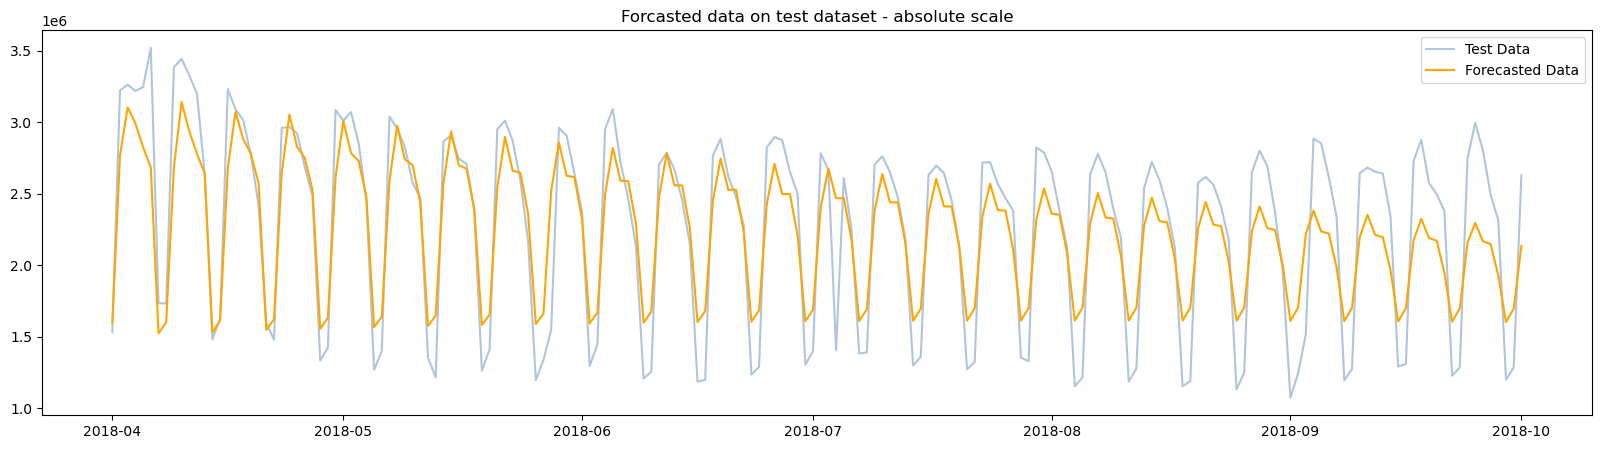

In [48]:
# Forcasted data in absolute scale

Train = np.exp(train_total['Sessions'])
Test = np.exp(test_total['Sessions'])
Forecast = np.exp(results)

plt.figure(figsize=[20,5])
plt.plot(Train, color='blue', label='Train Data')
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on whole dataset - absolute scale')
plt.legend()
plt.show()

plt.figure(figsize=[20,5])
plt.plot(Test, color='lightsteelblue', label='Test Data')
plt.plot(Forecast, color='orange', label='Forecasted Data')
plt.title('Forcasted data on test dataset - absolute scale')
plt.legend()
plt.show()

# CONCLUSION

Based on the evaluation of various models, SARIMA demonstrated the best performance, outperforming all other methods. The models can be ranked in terms of effectiveness as follows:

SARIMA -Provided the most reliable forecasts.

ARIMA - Performed well but fell short of SARIMAs robustness.

Autoregressive (AR) - Showed moderate predictive capabilities.

Moving Average (MA) - Delivered acceptable results but lacked precision compared to the top models.

Exponential Smoothing - Underperformed and was the least effective among the evaluated models.

These findings underscore the superior performance of SARIMA, making it the preferred choice for the given forecasting task.